In [4]:
import math
from typing import Dict, Callable
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
mnist = tf.keras.datasets.mnist

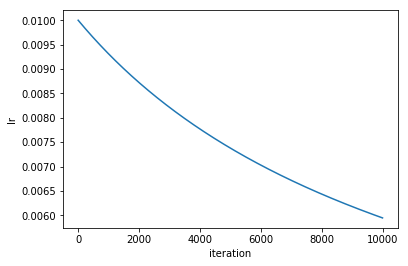

In [15]:
def _inv_lr(iteration_idx:int, gamma:float, power:float,  base_lr:float):
    'ported from: https://github.com/BVLC/caffe/blob/master/src/caffe/proto/caffe.proto#L157-L172'
    return base_lr * (1 + gamma * iteration_idx) ** (- power)

class InvSchedulerCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,
                 gamma:float,
                 power:float,
                 base_lr:float):
        'TODO: docstring'        
        self.gamma = gamma
        self.power = power
        self.base_lr = base_lr
        self.iteration = 0
    
    def on_batch_begin(self, batch, logs=None):
        'TODO: docstring'        
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = _inv_lr(self.iteration, self.gamma, self.power, self.base_lr)
        K.set_value(self.model.optimizer.lr, lr)
    
    def on_batch_end(self, batch, logs=None):
        'TODO: docstring'
        self.iteration +=1
       
    @staticmethod
    def plot_schedule(iterations:int, gamma:float, power:float,  base_lr:float):
        'TODO: docstring'   
        xs = range(iterations)
        ys = [_inv_lr(i, gamma, power, base_lr) for i in xs]
        df = pd.DataFrame({'lr' : ys, 'iteration': xs})
        sns.lineplot(x='iteration', y='lr', data=df)

gamma = 0.0001
power = 0.75
base_lr = 0.01
InvSchedulerCallback.plot_schedule(10000, gamma, power,base_lr)

In [2]:
def _1cycle_mom(iteration_idx:int,
                cyc_iterations:int,
                min_mom:float,
                max_mom:float):
    'TODO: docstring'
    mid = math.floor((cyc_iterations - 1)/2)
    if iteration_idx == mid: return min_mom
    elif iteration_idx == 0 or iteration_idx >= (2 * mid): return max_mom
    else:
        mod = (iteration_idx % mid)
        numerator =  mod if iteration_idx < mid else mid - mod
        return max_mom - (numerator / mid) * (max_mom - min_mom)

def _1cycle_lr(iteration_idx:int,
              cyc_iterations:int,
              ramp_iterations:int,
              min_lr:float,
              max_lr:float):
    'TODO: docstring'
    if cyc_iterations % 2 != 1:
        raise ValueError('Even value for `cyc_iterations` implies asymetric step size')
    mid = (cyc_iterations - 1)/2
    if iteration_idx == mid: return max_lr
    elif iteration_idx == 0 or iteration_idx == (2 * mid): return min_lr
    elif iteration_idx < cyc_iterations: 
        mod = (iteration_idx % mid)
        numerator =  mod if iteration_idx < mid else mid - mod
        return min_lr + (numerator / mid) * (max_lr - min_lr)
    else:
        idx = iteration_idx - cyc_iterations
        ramp_max = min_lr
        ramp_min = min_lr * 1e-5
        return ramp_max - ((idx + 1) / ramp_iterations) * (ramp_max - ramp_min)

class OneCycleSchedulerCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,
                 cyc_iterations:int,
                 ramp_iterations:int,
                 min_lr:float,
                 max_lr:float,
                 min_mom:float,
                 max_mom:float):
        'TODO: docstring'        
        self.cyc_iterations = cyc_iterations
        self.ramp_iterations = ramp_iterations
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_mom = min_mom
        self.max_mom = max_mom
        self.iteration = 0
    
    def on_batch_begin(self, batch, logs=None):
        'TODO: docstring'        
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        if not hasattr(self.model.optimizer, 'momentum'):
            raise ValueError('Optimizer must have a "momentum" attribute.')
        lr = _1cycle_lr(self.iteration, self.cyc_iterations, self.ramp_iterations, self.min_lr, self.max_lr)
        mom = _1cycle_mom(self.iteration, self.cyc_iterations, self.min_mom, self.max_mom)
        K.set_value(self.model.optimizer.lr, lr)
        K.set_value(self.model.optimizer.momentum, mom)   
    
    def on_batch_end(self, batch, logs=None):
        'TODO: docstring'
        self.iteration +=1
        
    @staticmethod
    def plot_schedule(cyc_iterations:int,
                      ramp_iterations:int,
                      min_lr:float,
                      max_lr:float,
                      min_mom:float,
                      max_mom:float):
        xs = range(cyc_iterations + ramp_iterations)
        lr_ys = [_1cycle_lr(i, cyc_iterations, ramp_iterations, min_lr, max_lr) for i in xs]
        mom_ys = [_1cycle_mom(i, cyc_iterations, min_lr, max_lr) for i in xs]
        lr_df = pd.DataFrame({'iteration': xs, 'lr' : lr_ys})
        mom_df = pd.DataFrame({'iteration': xs, 'mom' : mom_ys})
        _ ,(ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 20))
        sns.lineplot(x='iteration', y='lr', data= lr_df, ax=ax1)
        sns.lineplot(x='iteration', y='mom', data= mom_df, ax=ax2)
        
def _triangular_f(it:int, ss:int, min_lr:float, max_lr:float):
    'TODO: docstring'
    cyc = math.floor(it / (ss * 2))
    it_cyc = it - (cyc * 2 * ss)
    mid_dist = math.fabs(it_cyc - ss)
    scalar = mid_dist / ss
    return min_lr + (1 - scalar) * (max_lr - min_lr)

class LRFinderCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, step_size:int, min_lr:float, max_lr:float, evaluate_mod:int, evaluate_fn:Callable):
        'TODO: docstring'        
        super().__init__()
        self.step_size = step_size
        self.lr = min_lr
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.evaluate_mod = evaluate_mod
        self.evaluate_fn = evaluate_fn
        self.lrs = []
        self.its = []
        self.val_lrs = []
        self.val_loss = []
        self.val_acc = []
        self.iteration = 0
    
    def on_batch_begin(self, batch, logs=None):
        'TODO: docstring'
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        self.lr = _triangular_f(self.iteration, self.step_size, self.min_lr, self.max_lr)
        K.set_value(self.model.optimizer.lr, self.lr)
                
    def on_batch_end(self, batch, logs=None):
        'TODO: docstring'
        self.lrs.append(self.lr)
        self.its.append(self.iteration)
        if self.iteration % self.evaluate_mod == 0:
            self.val_lrs.append(self.lr)
            loss, acc = self.evaluate_fn()
            self.val_loss.append(loss)
            self.val_acc.append(acc)
        self.iteration += 1
        
    def plot_lr_vs_iteration(self):
        'TODO: docstring'        
        df = pd.DataFrame({'lr' : self.lrs, 'iteration': self.its})
        sns.lineplot(x='iteration', y='lr', data=df)
        
    def plot_lr_vs_loss(self):
        'TODO: docstring'        
        df = pd.DataFrame({'lr' : self.val_lrs, 'loss': self.val_loss})
        sns.lineplot(x='lr', y='loss', data=df)
        
    def plot_lr_vs_acc(self):
        'TODO: docstring'        
        df = pd.DataFrame({'lr' : self.val_lrs, 'acc': self.val_acc})
        sns.lineplot(x='lr', y='acc', data=df)

In [3]:
# mnist

def gen_model():
    'TODO: docstring'    
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=20,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=50,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

def gen_mnist_iterator(x, y, bs):
    'TODO: docstring'    
    x = (x / 255.0).astype(np.float32)[..., tf.newaxis]
    y = tf.one_hot(y, 10)
    ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(x.shape[0]).batch(bs).repeat()
    return ds.make_one_shot_iterator()

In [7]:
# STEPWISE TRAIN

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_xs, train_ys = gen_mnist_iterator(x_train, y_train, 512).get_next()
test_xs, test_ys = gen_mnist_iterator(x_test, y_test, 512).get_next()
model = gen_model()
opt = tf.keras.optimizers.SGD(0.01, decay=5e-4, momentum=0.9)
train_steps = math.ceil(x_train.shape[0] / 512)
test_steps = math.ceil(x_test.shape[0] / 512)
model.compile(opt, 
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(train_xs, train_ys, epochs=20, steps_per_epoch=train_steps)
model.evaluate(test_xs, test_ys, steps=test_steps)

Epoch 1/20
118/118 [==============================] - 38s 324ms/step - loss: 0.7448 - acc: 0.7961
Epoch 2/20
118/118 [==============================] - 1s 10ms/step - loss: 0.1769 - acc: 0.9468
Epoch 3/20
118/118 [==============================] - 1s 10ms/step - loss: 0.1187 - acc: 0.9648
Epoch 4/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0890 - acc: 0.9737
Epoch 5/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0768 - acc: 0.9766
Epoch 6/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0676 - acc: 0.9801
Epoch 7/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0574 - acc: 0.9831
Epoch 8/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0532 - acc: 0.9842
Epoch 9/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0484 - acc: 0.9856
Epoch 10/20
118/118 [==============================] - 1s 10ms/step - loss: 0.0445 - acc: 0.9869
Epoch 11/20
118/118 [================

[0.03403067998588085, 0.9884248614311218]

Epoch 1/1
118/118 [==============================] - 36s 302ms/step - loss: 0.7783 - acc: 0.7690


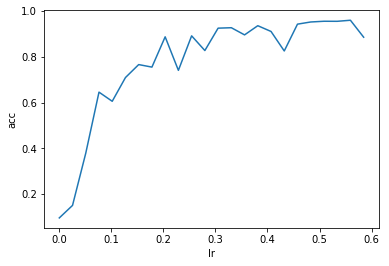

In [5]:
# MNIST LR RANGE TEST

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_xs, train_ys = gen_mnist_iterator(x_train, y_train, 512).get_next()
test_xs, test_ys = gen_mnist_iterator(x_test, y_test, 512).get_next()
model = gen_model()
opt = tf.keras.optimizers.SGD(0.01)
train_steps = math.ceil(x_train.shape[0] / 512)
test_steps = math.ceil(x_test.shape[0] / 512)
cb = LRFinderCallback(step_size=train_steps,
                      min_lr=1e-4,
                      max_lr=0.6,
                      evaluate_mod=5,
                      evaluate_fn= lambda: model.evaluate(test_xs, test_ys, steps=test_steps))
model.compile(opt, 
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(train_xs, train_ys, epochs=1, steps_per_epoch=train_steps, callbacks=[cb])
cb.plot_lr_vs_acc()

In [4]:
# MNIST 1CYCLE TRAIN

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_xs, train_ys = gen_mnist_iterator(x_train, y_train, 512).get_next()
test_xs, test_ys = gen_mnist_iterator(x_test, y_test, 512).get_next()
model = gen_model()
opt = tf.keras.optimizers.SGD(0.01, decay=5e-4)
train_steps = math.ceil(x_train.shape[0] / 512)
test_steps = math.ceil(x_test.shape[0] / 512)
cb = OneCycleSchedulerCallback(cyc_iterations= 2 * 5 * math.ceil(60000 / 512) + 1,
                               ramp_iterations= 2 * math.ceil(60000 / 512),
                               min_lr=0.01,
                               max_lr=0.1,
                               min_mom=0.8,
                               max_mom=0.95)
model.compile(opt, 
              loss='categorical_crossentropy',
              metrics=['acc'])
model.fit(train_xs, train_ys, epochs=12, steps_per_epoch=train_steps, callbacks=[cb])
model.evaluate(test_xs, test_ys, steps=test_steps)

Epoch 1/12
118/118 [==============================] - 34s 288ms/step - loss: 0.6891 - acc: 0.7977
Epoch 2/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0955 - acc: 0.9714
Epoch 3/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0614 - acc: 0.9811
Epoch 4/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0469 - acc: 0.9854
Epoch 5/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0345 - acc: 0.9892
Epoch 6/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0278 - acc: 0.9911
Epoch 7/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0207 - acc: 0.9937
Epoch 8/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0161 - acc: 0.9952
Epoch 9/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0115 - acc: 0.9969
Epoch 10/12
118/118 [==============================] - 1s 11ms/step - loss: 0.0086 - acc: 0.9980
Epoch 11/12
118/118 [================

[0.03209905261173844, 0.9899988502264023]

In [18]:
# bs fixed: 0.9907
# lr_max 0.2: 0.9903
# wd 0: 0.99050
# wd 1e-5: 0.99059
# no wd, shit shuffle: 0.9903

400/400 [==============================] - 13s 33ms/step


[0.03281834803987294, 0.9903808590769768]

In [ ]:
# --- TOY EXAMPLES

50/50 [==============================] - 0s 69us/step


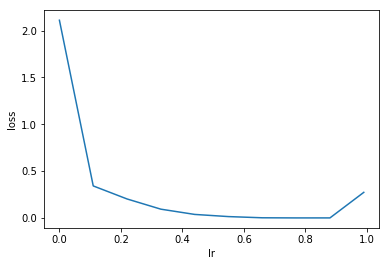

In [223]:
# LRFinder test run

n = 100
bs = 10
x = np.random.sample([n, 1])
y = x * 2 + np.random.normal(0, 0.01, [n, 1])
test_x = np.random.sample([int(n/2), 1])
test_y = test_x * 2 + np.random.normal(0, 0.01, [int(n/2), 1])
xs = tf.keras.Input(shape=(1,))
ys = tf.keras.Input(shape=(1,))
out = tf.keras.layers.Dense(1)(xs)
model = tf.keras.Model(xs, out)
model.compile('sgd', 'mse', metrics=['acc'])
cb = LRFinderCallback(step_size=100,
                      min_lr=1e-6,
                      max_lr=1.1,
                      evaluate_mod=10,
                      evaluate_fn= lambda: model.evaluate(test_x, test_y))
model.fit(x, y, epochs=10, batch_size=10, callbacks=[cb], verbose=0)
cb.plot_lr_vs_loss()

In [217]:
# 1cycle test run

n = 100
bs = 10
x = np.random.sample([n, 1])
y = x * 2 + np.random.normal(0, 0.01, [n, 1])
xs = tf.keras.Input(shape=(1,))
ys = tf.keras.Input(shape=(1,))
out = tf.keras.layers.Dense(1)(xs)
model = tf.keras.Model(xs, out)
model.compile('sgd', 'mse')
cb = OneCycleSchedulerCallback(29, 1, min_lr=1e-6, max_lr=0.8, min_mom=0.8, max_mom=0.95)
model.fit(x, y, epochs=3, batch_size=10, callbacks=[cb])

Epoch 1/3
100/100 [==============================] - 3s 30ms/step - loss: 1.2151
Epoch 2/3
100/100 [==============================] - 0s 228us/step - loss: 0.1359
Epoch 3/3
100/100 [==============================] - 0s 273us/step - loss: 0.0366


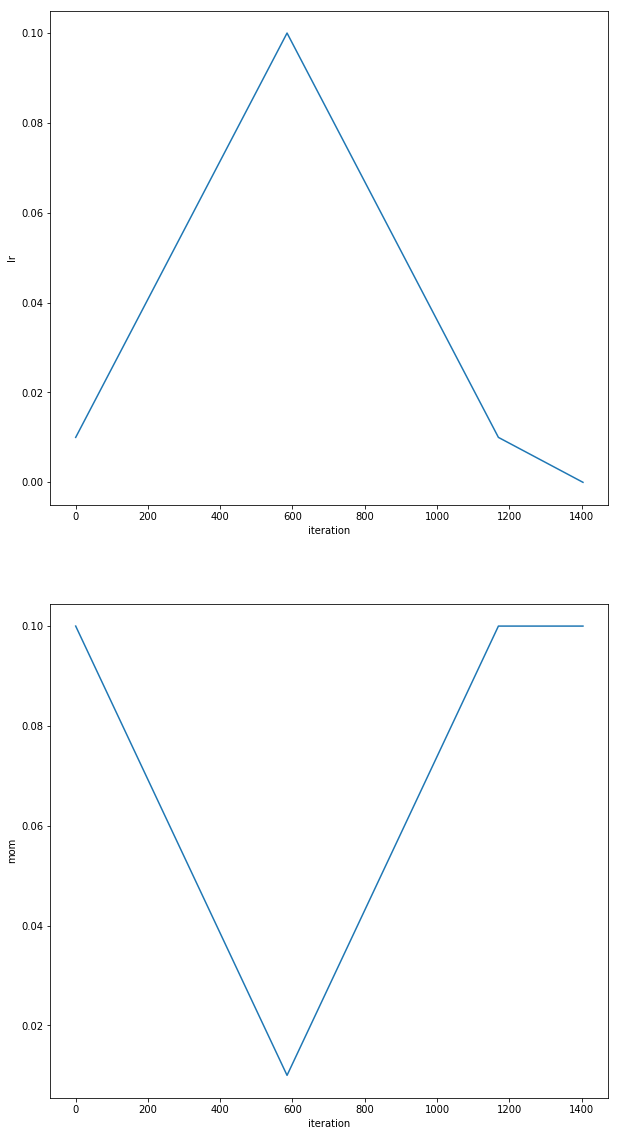

In [176]:
# ie: MNIST lr: 0.01-0.1/5, momentum: 0.95-0.8/5
n = 60000
bs = 512
cyc_it = 10 * math.floor(n / bs)
ramp_it = 2 * math.floor(n / bs)
OneCycleSchedulerCallback.plot_schedule(cyc_it + 1, ramp_it, 0.01, 0.1, 0.8, 0.95)

In [ ]:
# TODO: Move to tf_warmup

In [3]:
# MNIST: NUMPY -> KERAS

def gen_model():
    'TODO: docstring'    
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(input_shape=(28, 28, 1),
                               filters=20,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=50,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = (x_train / 255.0).astype(np.float32), (x_test / 255.0).astype(np.float32)
y_train, y_test = y_train.astype(np.float32), y_test.astype(np.float32)
x_train = x_train[..., tf.newaxis]
model = gen_model()
opt = tf.keras.optimizers.SGD(0.01)
model.compile(opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x=x_train, y=y_train, epochs=1, batch_size=32)

Epoch 1/1
60000/60000 [==============================] - 7s 109us/step - loss: 0.4046 - acc: 0.8839


In [4]:
# MNIST: DATASET -> KERAS

def gen_model():
    'TODO: docstring'    
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(filters=20,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=50,
                               kernel_size=5),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')])

(x_train, y_train), _ = mnist.load_data()
x_train = (x_train / 255.0).astype(np.float32)[..., tf.newaxis]
y_train = tf.one_hot(y_train, 10)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(100).batch(32)
train_it = train_ds.make_one_shot_iterator()
xs, ys = train_it.get_next()
model = gen_model()
opt = tf.keras.optimizers.SGD(0.01)
steps = math.floor(x_train.shape[0] / 32)
model.compile(opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(xs, ys, epochs=1, steps_per_epoch=steps)

Epoch 1/1
1875/1875 [==============================] - 26s 14ms/step - loss: 0.4057 - acc: 0.8901
